# Simulation Library Demo

In [51]:
from class_multisimulation import MultiSimulation
from class_simulationhelper import SimulationHelpers
from class_basesimulation import BaseSimulation
import matplotlib.pyplot as plt

bs = BaseSimulation()
ms = MultiSimulation()
helper = SimulationHelpers()


outlier added at indices 89, 44, 36, 30, 48, 68, 98, 29, 52, 63


Text(0.5, 0, 'Added Outliers')

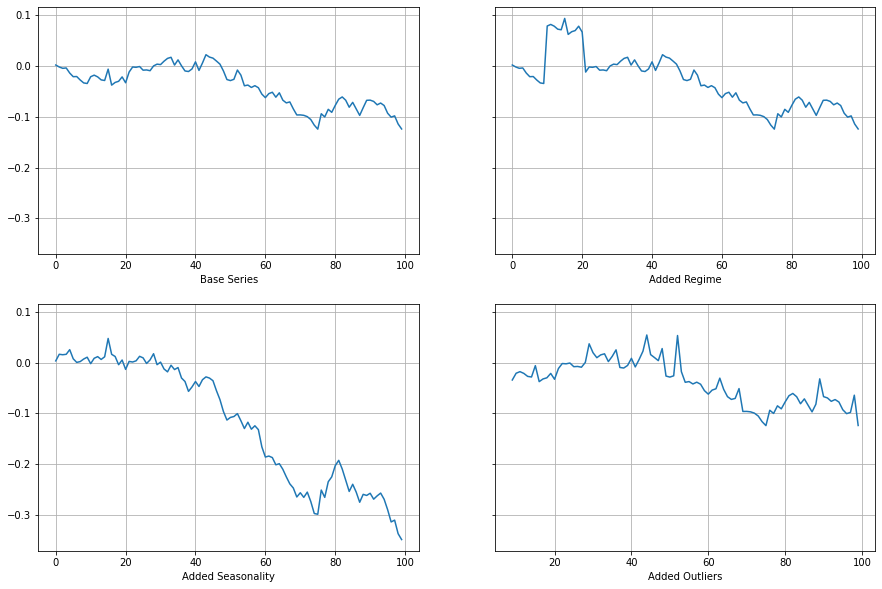

In [64]:
s0 = bs.brownian_process(100, mu = 0, S0 = 1, sigma = 0.1)
s1 = bs.add_regime_change(s0, event_index = 10, shift = 0.1, regime_limit = 10)
s2 = bs.add_seasonality(s0, start_idx = 10, how_diffusion="sqrt", amp = 3, contamination=0.1, freq = 100)
s3 = bs.add_outlier(s0, thresh=3, how = "full_random", count = 10)
ax = helper.plot(s0, s1, s2, s3, figsize=(15, 10), row_lim = 2)
ax[0,0].set_xlabel("Base Series")
ax[0,1].set_xlabel("Added Regime")
ax[1,0].set_xlabel("Added Seasonality")
ax[1,1].set_xlabel("Added Outliers")

outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 66, 10, 64, 45, 70, 22, 89, 55, 90, 45
outlier added at indices 20, 35
outlier added at indices 80
outlier added at indices 30


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[66 10 64 45 70 22 89 55 90 45]. Argument 'count' overridden.
  warnings.warn(
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[20, 35]. Argument 'count' overridden.
  warnings.warn(
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[80]. Argument 'count' overridden.
  warnings.warn(
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\class_basesimulation.py:271: UserWarning: Specified random_mag with fixed indices[30]. Argument 'count' overridden.
  warnings.warn(


Text(0.5, 0.98, 'Systematic Outliers in Rainbow; Idiosyncratic Outliers in Black')

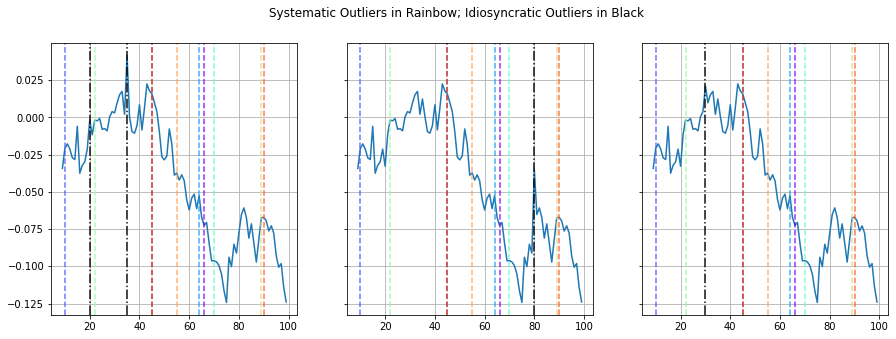

In [75]:
t0 = ms.correlated_brownian_processes_with_CO(100, how = "full_random", count = 10, mu = 0, cov_mat = helper.gen_rand_cov_mat(3, random_seed=12), random_seed=12)
io0 = [20, 35]
io1 = [80]
io2 = [30]
t0[0] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io0)
t0[1] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io1)
t0[2] = bs.add_outlier(s0, thresh=3, how = "random_mag", count = 10, outlier_indices=io2)
ax = helper.plot(*t0, figsize = (15, 5), outliers = [[66, 10, 64, 45, 70, 22, 89, 55, 90, 45] for _ in range(3)])
for idio in io0:
    ax[0].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
for idio in io1:
    ax[1].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
for idio in io2:
    ax[2].axvline(idio , color="black", linestyle="dashdot",alpha=0.95)
plt.suptitle("Systematic Outliers in Rainbow; Idiosyncratic Outliers in Black")

In [76]:
# Graph different architecture loss descents
# All copied from new_fit.ipynb
import tensorflow as tf
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generation import gen_data
# from pyod.utils import pairwise_distances_no_broadcast
# from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model_Base
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, temporalize, reconstruction, get_outliers

featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(25)

n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape


(2503, 24)

In [77]:
seq_size = 5
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)


In [81]:
architectures = [
    [128, 64, 64, 128],
    [128, 64, 32, 32, 64, 128],
    [128, 32, 32, 128],
    [64, 32, 32, 64],
    [32, 16, 16, 32],
    [128, 16, 16, 128]
]

histories = {"-".join([str(i) for i in arch]):[] for arch in architectures}

for arch in architectures:
    lstm_pred, lstm_outliers, history = lstm_run(
        LSTM_Model_Base(
            seq_size, 
            n_feature, 
            arch, 
            mid_activation=tf.nn.tanh
        ),
        data_train_seq,
        data_test_seq,
        batch_size=512,
        epoch=100,
        metric="bb",
        early_stopping=False,
        cross_feature_check=True
    )

    histories["-".join([str(i) for i in arch])] = history


Epoch 1/100
3/3 [==============================] - 6s 64ms/step - loss: 1.0156
Epoch 2/100
3/3 [==============================] - 0s 62ms/step - loss: 1.0146
Epoch 3/100
3/3 [==============================] - 0s 62ms/step - loss: 1.0131
Epoch 4/100
3/3 [==============================] - 0s 63ms/step - loss: 1.0107
Epoch 5/100
3/3 [==============================] - 0s 62ms/step - loss: 1.0069
Epoch 6/100
3/3 [==============================] - 0s 62ms/step - loss: 1.0017
Epoch 7/100
3/3 [==============================] - 0s 64ms/step - loss: 0.9973
Epoch 8/100
3/3 [==============================] - 0s 71ms/step - loss: 0.9933
Epoch 9/100
3/3 [==============================] - 0s 76ms/step - loss: 0.9885
Epoch 10/100
3/3 [==============================] - 0s 74ms/step - loss: 0.9833
Epoch 11/100
3/3 [==============================] - 0s 64ms/step - loss: 0.9779
Epoch 12/100
3/3 [==============================] - 0s 63ms/step - loss: 0.9723
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 6ms/step
Epoch 1/100


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 8s 92ms/step - loss: 1.0158
Epoch 2/100
3/3 [==============================] - 0s 93ms/step - loss: 1.0157
Epoch 3/100
3/3 [==============================] - 0s 91ms/step - loss: 1.0156
Epoch 4/100
3/3 [==============================] - 0s 104ms/step - loss: 1.0155
Epoch 5/100
3/3 [==============================] - 0s 127ms/step - loss: 1.0154
Epoch 6/100
3/3 [==============================] - 0s 93ms/step - loss: 1.0151
Epoch 7/100
3/3 [==============================] - 0s 90ms/step - loss: 1.0144
Epoch 8/100
3/3 [==============================] - 0s 91ms/step - loss: 1.0128
Epoch 9/100
3/3 [==============================] - 0s 114ms/step - loss: 1.0102
Epoch 10/100
3/3 [==============================] - 0s 105ms/step - loss: 1.0082
Epoch 11/100
3/3 [==============================] - 0s 96ms/step - loss: 1.0051
Epoch 12/100
3/3 [==============================] - 0s 102ms/step - loss: 1.0022
Epoch 13/100
3/3 [==============================] - 0s 9

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 9ms/step
Epoch 1/100


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 6s 100ms/step - loss: 1.0156
Epoch 2/100
3/3 [==============================] - 0s 122ms/step - loss: 1.0149
Epoch 3/100
3/3 [==============================] - 0s 124ms/step - loss: 1.0140
Epoch 4/100
3/3 [==============================] - 0s 126ms/step - loss: 1.0125
Epoch 5/100
3/3 [==============================] - 0s 124ms/step - loss: 1.0102
Epoch 6/100
3/3 [==============================] - 0s 125ms/step - loss: 1.0068
Epoch 7/100
3/3 [==============================] - 0s 126ms/step - loss: 1.0022
Epoch 8/100
3/3 [==============================] - 0s 140ms/step - loss: 0.9981
Epoch 9/100
3/3 [==============================] - 0s 133ms/step - loss: 0.9952
Epoch 10/100
3/3 [==============================] - 0s 126ms/step - loss: 0.9914
Epoch 11/100
3/3 [==============================] - 0s 123ms/step - loss: 0.9872
Epoch 12/100
3/3 [==============================] - 0s 129ms/step - loss: 0.9830
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 7ms/step
Epoch 1/100


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 6s 113ms/step - loss: 1.0158
Epoch 2/100
3/3 [==============================] - 0s 119ms/step - loss: 1.0153
Epoch 3/100
3/3 [==============================] - 0s 115ms/step - loss: 1.0148
Epoch 4/100
3/3 [==============================] - 0s 109ms/step - loss: 1.0142
Epoch 5/100
3/3 [==============================] - 0s 109ms/step - loss: 1.0133
Epoch 6/100
3/3 [==============================] - 0s 112ms/step - loss: 1.0120
Epoch 7/100
3/3 [==============================] - 0s 112ms/step - loss: 1.0101
Epoch 8/100
3/3 [==============================] - 0s 106ms/step - loss: 1.0074
Epoch 9/100
3/3 [==============================] - 0s 110ms/step - loss: 1.0042
Epoch 10/100
3/3 [==============================] - 0s 110ms/step - loss: 1.0012
Epoch 11/100
3/3 [==============================] - 0s 115ms/step - loss: 0.9989
Epoch 12/100
3/3 [==============================] - 0s 123ms/step - loss: 0.9960
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 5ms/step
Epoch 1/100


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 5s 52ms/step - loss: 1.0159
Epoch 2/100
3/3 [==============================] - 0s 52ms/step - loss: 1.0157
Epoch 3/100
3/3 [==============================] - 0s 53ms/step - loss: 1.0155
Epoch 4/100
3/3 [==============================] - 0s 52ms/step - loss: 1.0153
Epoch 5/100
3/3 [==============================] - 0s 53ms/step - loss: 1.0150
Epoch 6/100
3/3 [==============================] - 0s 52ms/step - loss: 1.0147
Epoch 7/100
3/3 [==============================] - 0s 55ms/step - loss: 1.0142
Epoch 8/100
3/3 [==============================] - 0s 59ms/step - loss: 1.0136
Epoch 9/100
3/3 [==============================] - 0s 61ms/step - loss: 1.0128
Epoch 10/100
3/3 [==============================] - 0s 61ms/step - loss: 1.0118
Epoch 11/100
3/3 [==============================] - 0s 59ms/step - loss: 1.0105
Epoch 12/100
3/3 [==============================] - 0s 52ms/step - loss: 1.0088
Epoch 13/100
3/3 [==============================] - 0s 53ms/s

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 4ms/step
Epoch 1/100


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


3/3 [==============================] - 7s 154ms/step - loss: 1.0158
Epoch 2/100
3/3 [==============================] - 0s 152ms/step - loss: 1.0154
Epoch 3/100
3/3 [==============================] - 0s 143ms/step - loss: 1.0149
Epoch 4/100
3/3 [==============================] - 0s 143ms/step - loss: 1.0142
Epoch 5/100
3/3 [==============================] - 0s 143ms/step - loss: 1.0132
Epoch 6/100
3/3 [==============================] - 0s 142ms/step - loss: 1.0115
Epoch 7/100
3/3 [==============================] - 0s 143ms/step - loss: 1.0089
Epoch 8/100
3/3 [==============================] - 0s 155ms/step - loss: 1.0055
Epoch 9/100
3/3 [==============================] - 0s 159ms/step - loss: 1.0016
Epoch 10/100
3/3 [==============================] - 0s 141ms/step - loss: 0.9985
Epoch 11/100
3/3 [==============================] - 0s 141ms/step - loss: 0.9955
Epoch 12/100
3/3 [==============================] - 0s 140ms/step - loss: 0.9924
Epoch 13/100
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 9ms/step


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  check_idx =  np.array([
c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


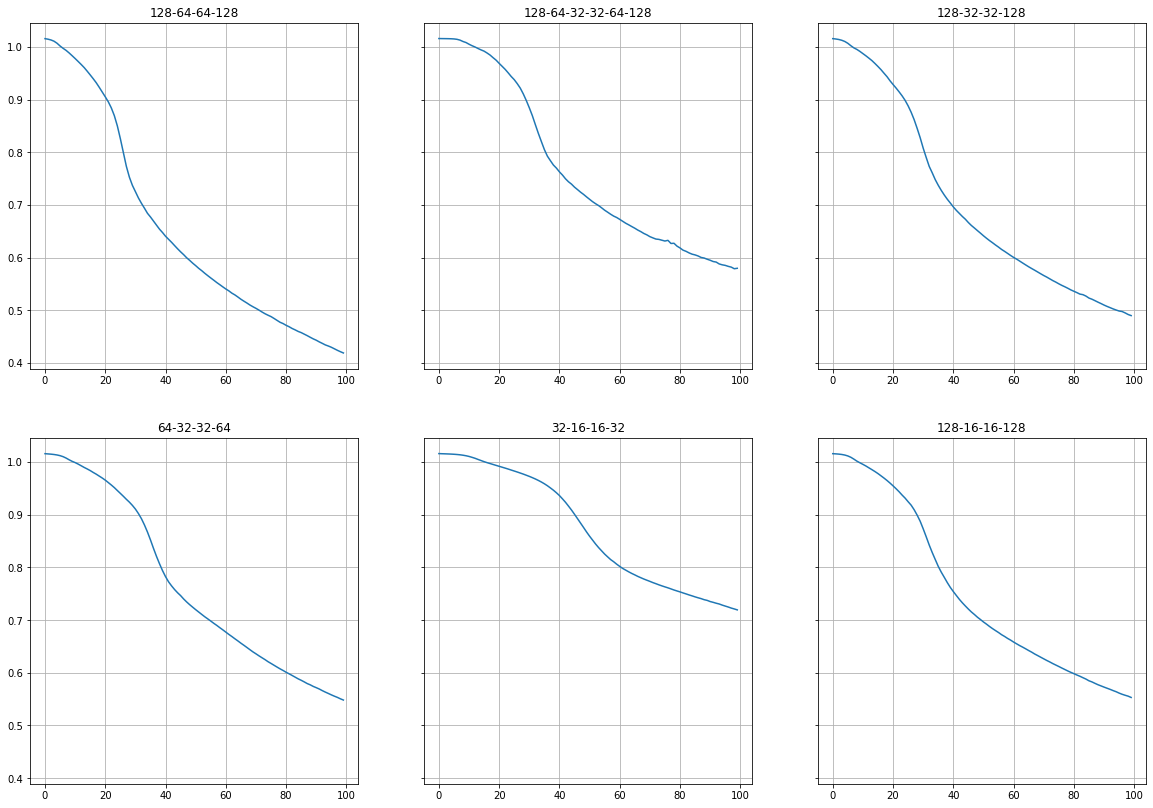

In [107]:
loss = {key: val.history["loss"] for key, val in histories.items()}
ax_loss = helper.plot(*np.array([val for val in loss.values()]), row_lim = 3)
for key, ax in zip(loss.keys(), ax_loss.reshape(-1)):
    ax.set_title(key)

In [104]:
# [val for key, val in loss.items()]
np.array([val for val in loss.values()])

array([[1.01560736, 1.01458013, 1.01307762, 1.01072514, 1.00686562,
        1.00168622, 0.99726105, 0.99332142, 0.98850328, 0.98325002,
        0.97788554, 0.97230774, 0.96664417, 0.96069872, 0.95385969,
        0.94678861, 0.93954837, 0.93192309, 0.92323923, 0.9142065 ,
        0.90519708, 0.89575881, 0.88420379, 0.869537  , 0.85008085,
        0.82585078, 0.79945517, 0.77314967, 0.75270545, 0.73716408,
        0.72524923, 0.71327209, 0.70310986, 0.69381118, 0.68414599,
        0.67714071, 0.66940057, 0.66165602, 0.65395951, 0.64761633,
        0.64056361, 0.63480151, 0.62906218, 0.62286228, 0.61676788,
        0.61099654, 0.60567355, 0.59976739, 0.59480506, 0.58953798,
        0.58478796, 0.57970065, 0.57528186, 0.57037634, 0.56584436,
        0.5614239 , 0.55714279, 0.55270243, 0.54868364, 0.54452592,
        0.54051238, 0.53691381, 0.53261554, 0.52928543, 0.52526826,
        0.52105916, 0.51737297, 0.51384801, 0.5100702 , 0.50679195,
        0.50374669, 0.50041258, 0.49684134, 0.49